# **TimeGAN**
Unofficial implementation in PyTorch.

Jinsung Yoon, Daniel Jarrett, Mihaela van der Schaar, "Time-series Generative Adversarial Networks," Neural Information Processing Systems (NeurIPS), 2019.

Notebook Author: https://github.com/haufjan

### **Import**

In [1]:
import os
import time
from itertools import chain, cycle

import numpy as np
import pandas as pd

import torch
from torch import nn, tensor
from torch.utils.data import TensorDataset, DataLoader

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.utils import shuffle

import matplotlib as mpl
import matplotlib.pyplot as plt

### **Random Seeds**

In [2]:
np.random.seed(42)
torch.seed(42)

### **Functions**

In [3]:
def loading(*files: str) -> pd.DataFrame:
    """
    Load data from csv file
    """
    return_list = []
    for file in files:
        path = f'{file}' if file.endswith('csv') else f'{file}.csv'
        return_list.extend([pd.read_csv(path)])

    return return_list if len(return_list) > 1 else return_list.pop()

In [4]:
def preprocessing(*inputs: tuple, horizon: int, shuffle_stack: bool = True, random_state: int = None) -> np.ndarray:
    """
    Conduct preprocessing: scale data, slice data into sequences and shuffle data stack
    """
    return_list = []
    for data, bool_scale in inputs:
        #Create Minimum-Maximum scaler
        if bool_scale:
            scaler = MinMaxScaler().fit(data)
            data = scaler.transform(data)
            print('\nMaximum values:\n', scaler.data_max_, '\nMinimum values:\n', scaler.data_min_)

        #Create a list holding the sequences defined by sliding window of width = horizon and stack to a 3-dimensional array (batch, horizon, feature)
        data_stack = np.stack([data[i:i+horizon] for i in range(len(data) - horizon)])

        if shuffle_stack:
            #In TimeGAN code the dataset is mixed to make it similar to independent and identically distributed (iid)
            data_stack = shuffle(data_stack, random_state=random_state)

        return_list.extend([data_stack, scaler.data_max_, scaler.data_min_]) if bool_scale else return_list.extend([data_stack])

    return return_list if len(return_list) > 1 else return_list.pop()

In [5]:
def low_dimensional_representation(data_ori: np.ndarray, data_gen: np.ndarray, technique: str) -> np.ndarray:
    """
    Transform data into low-dimensional representation
    """
    assert technique in ['pca', 'tsne']

    sample_no = min([1000, len(data_ori)])
    idx = np.random.permutation(len(data_ori))[:sample_no]
    data_ori, data_gen = np.asarray(data_ori)[idx], np.asarray(data_gen)[idx]
    no, seq_len, dim = data_ori.shape

    prep_data = np.array([np.reshape(np.mean(data_ori[i,:,:], 1), [1,seq_len]).flatten().tolist() for i in range(sample_no)])
    prep_data_hat = np.array([np.reshape(np.mean(data_gen[i,:,:], 1), [1,seq_len]).flatten().tolist() for i in range(sample_no)])

    if technique == 'pca':
        # PCA Analysis
        pca = PCA(n_components = 2)
        pca.fit(prep_data)

        return pca.transform(prep_data), pca.transform(prep_data_hat)

    elif technique == 'tsne':
        # Do t-SNE Analysis together
        prep_data_final = np.concatenate((prep_data, prep_data_hat), axis = 0)

        # TSNE anlaysis
        tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, max_iter = 300)
        tsne_result = tsne.fit_transform(prep_data_final)

        return tsne_result[:sample_no], tsne_result[sample_no:]

In [6]:
def plot_distribution_estimate(lowdim_data_ori: np.ndarray, lowdim_data_gen: np.ndarray, technique: str) -> None:
    """
    Visualize distribution estimate via sampled data points
    """
    fig, ax = plt.subplots()
    #Use rasterized Line2D Artist here instead of scatter. Espacially benefitial when exporting the plot as pdf file (or other vector graphics).
    ax.add_line(mpl.lines.Line2D(lowdim_data_ori[:,0], lowdim_data_ori[:,1], ls='', marker='o', markersize=3, c = 'red', alpha = 0.2, rasterized=True, label='Original'))
    ax.add_line(mpl.lines.Line2D(lowdim_data_gen[:,0], lowdim_data_gen[:,1], ls='', marker='o', markersize=3, c = 'blue', alpha = 0.2, rasterized=True, label='Generated'))
    ax.autoscale_view()
    ax.set_xlabel(f'x-{technique}')
    ax.set_ylabel(f'y-{technique}')
    ax.legend()
    fig.show()

### **Load and prepare Data**

In [7]:
#Data set
data = loading(os.path.join('stock_data'))

#Squence length
HORIZON = 24

#Flip stock_data to make it chronological
data = np.asarray(data)[::-1]

#Preprocess data
data_train, max_val, min_val = preprocessing((data, True), horizon=HORIZON)


Maximum values:
 [1.27100000e+03 1.27389001e+03 1.24902002e+03 1.26832996e+03
 1.26832996e+03 8.27681000e+07] 
Minimum values:
 [  49.274517   50.541279   47.669952   49.681866   49.681866 7900.      ]


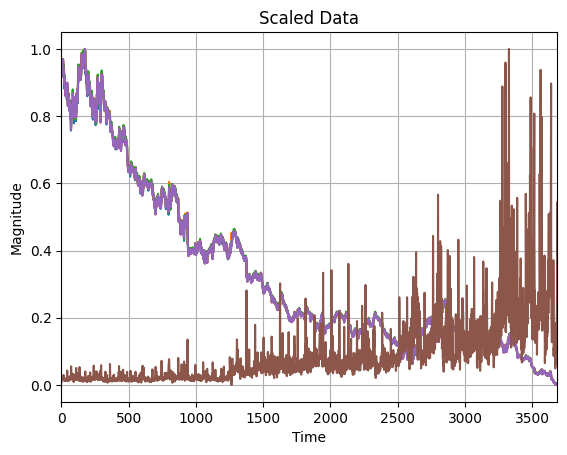

In [8]:
#Visualize scaled training data
fig, ax = plt.subplots()
ax.plot((data - min_val)/(max_val - min_val))
ax.set_xlim(0, len(data))
ax.set_xlabel('Time')
ax.set_ylabel('Magnitude')
ax.set_title('Scaled Data')
ax.grid(True)
fig.show()

### **Device**

In [9]:
device = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
)
print(f'Using {device} device')

Using cuda device


### **Networks**

##### **Embedder**

In [10]:
class Embedder(nn.Module):
    def __init__(self, module_name, input_features, hidden_dim, num_layers):
        super().__init__()
        assert module_name in ['gru', 'lstm']
        if module_name == 'gru':
            self.rnn = nn.GRU(input_size=input_features, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        elif module_name == 'lstm':
            self.rnn = nn.LSTM(input_size=input_features, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        else:
            raise Exception()
        self.model = nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                   nn.Sigmoid())

    def forward(self, x):
        seq, _ = self.rnn(x)
        return self.model(seq)

##### **Recovery**

In [11]:
class Recovery(nn.Module):
    def __init__(self, module_name, input_features, hidden_dim, num_layers):
        super().__init__()
        assert module_name in ['gru', 'lstm']
        if module_name == 'gru':
            self.rnn = nn.GRU(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        elif module_name == 'lstm':
            self.rnn = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        else:
            raise Exception()
        self.model = nn.Sequential(nn.Linear(hidden_dim, input_features),
                                   nn.Sigmoid())

    def forward(self, x):
        seq, _ = self.rnn(x)
        return self.model(seq)

##### **Generator**

In [12]:
class Generator(nn.Module):
    def __init__(self, module_name, input_features, hidden_dim, num_layers):
        super().__init__()
        assert module_name in ['gru', 'lstm']
        if module_name == 'gru':
            self.rnn = nn.GRU(input_size=input_features, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        elif module_name == 'lstm':
            self.rnn = nn.LSTM(input_size=input_features, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        else:
            raise Exception()
        self.model = nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                   nn.Sigmoid())

    def forward(self, x):
        seq, _ = self.rnn(x)
        return self.model(seq)

##### **Supervisor**

In [13]:
class Supervisor(nn.Module):
    def __init__(self, module_name, hidden_dim, num_layers):
        super().__init__()
        assert module_name in ['gru', 'lstm']
        if module_name == 'gru':
            self.rnn = nn.GRU(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=num_layers-1, batch_first=True)
        elif module_name == 'lstm':
            self.rnn = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=num_layers-1, batch_first=True)
        else:
            raise Exception()
        self.model = nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                   nn.Sigmoid())

    def forward(self, x):
        seq, _ = self.rnn(x)
        return self.model(seq)

##### **Discriminator**

In [14]:
class Discriminator(nn.Module):
    def __init__(self, module_name, hidden_dim, num_layers):
        super().__init__()
        assert module_name in ['gru', 'lstm']
        if module_name == 'gru':
            self.rnn = nn.GRU(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=num_layers, bidirectional=True, batch_first=True)
        elif module_name == 'lstm':
            self.rnn = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=num_layers, bidirectional=True, batch_first=True)
        else:
            raise Exception()
        self.model = nn.Linear(2*hidden_dim, 1)

    def forward(self, x):
        seq, _ = self.rnn(x)
        return self.model(seq)

### **Loss Functions**

In [15]:
def embedder_loss(x, x_tilde):
    return 10*torch.sqrt(nn.MSELoss()(x_tilde, x))

In [16]:
def supervised_loss(h, h_hat_supervise):
    return nn.MSELoss()(h_hat_supervise[:,:-1,:], h[:,1:,:])

In [17]:
def generator_loss(y_fake, y_fake_e, h, h_hat_supervise, x, x_hat):
    gamma = 1
    fake = torch.ones_like(y_fake, dtype=torch.float32, device=device, requires_grad=False)

    #1. Unsupervised generator loss
    g_loss_u = nn.BCEWithLogitsLoss()(y_fake, fake)
    g_loss_u_e = nn.BCEWithLogitsLoss()(y_fake_e, fake)

    #2. Supervised loss
    g_loss_s = nn.MSELoss()(h_hat_supervise[:,:-1,:], h[:,1:,:])

    #3. Two moments
    g_loss_v1 = torch.mean(torch.abs(torch.sqrt(torch.std(x_hat, dim=0)) - torch.sqrt(torch.std(x, dim=0))))
    g_loss_v2 = torch.mean(torch.abs(torch.mean(x_hat, dim=0) - torch.mean(x, dim=0)))
    g_loss_v = g_loss_v1 + g_loss_v2

    return g_loss_u + gamma * g_loss_u_e + 100 * torch.sqrt(g_loss_s) + 100 * g_loss_v

In [18]:
def discriminator_loss(y_real, y_fake, y_fake_e):
    gamma = 1
    valid = torch.ones_like(y_real, dtype=torch.float32, device=device, requires_grad=False)
    fake = torch.zeros_like(y_fake, dtype=torch.float32, device=device, requires_grad=False)

    d_loss_real = nn.BCEWithLogitsLoss()(y_real, valid)
    d_loss_fake = nn.BCEWithLogitsLoss()(y_fake, fake)
    d_loss_fake_e = nn.BCEWithLogitsLoss()(y_fake_e, fake)

    return d_loss_real + d_loss_fake + d_loss_fake_e * gamma

### **TimeGAN**

In [19]:
class TimeGAN(nn.Module):
    def __init__(self,
                 module_name: str = 'gru',
                 input_features: int = 1,
                 hidden_dim: int = 8,
                 num_layers: int = 3,
                 epochs: int = 100,
                 batch_size: int = 128,
                 learning_rate: float = 1e-3):

        super().__init__()
        #Parameters
        self.module_name = module_name
        self.input_features = input_features
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate

        #Networks
        self.embedder = Embedder(module_name, input_features, hidden_dim, num_layers)
        self.recovery = Recovery(module_name, input_features, hidden_dim, num_layers)
        self.generator = Generator(module_name, input_features, hidden_dim, num_layers)
        self.supervisor = Supervisor(module_name, hidden_dim, num_layers)
        self.discriminator = Discriminator(module_name, hidden_dim, num_layers)

        #Optimizers
        self.optimizer_e = torch.optim.Adam(chain(self.embedder.parameters(), self.recovery.parameters()), lr=learning_rate)
        self.optimizer_g = torch.optim.Adam(chain(self.generator.parameters(), self.supervisor.parameters()), lr=learning_rate)
        self.optimizer_d = torch.optim.Adam(self.discriminator.parameters(), lr=learning_rate)

        #Loss functions
        self.embedder_loss = embedder_loss
        self.supervised_loss = supervised_loss
        self.generator_loss = generator_loss
        self.discriminator_loss = discriminator_loss

        #Auxiliary
        self.fitting_time = None
        self.losses = []

    def fit(self, data_train: np.ndarray):
        """
        Train TimeGAN model in three subsequent training phases
        """
        self.fitting_time = time.time()
        data_train = tensor(data_train, dtype=torch.float32, device=device)

        #1. Embedding network training
        print('Start Embedding Network Training')
        for epoch, frame in zip(range(self.epochs), cycle(r'-\|/-\|/')):
            batches_train = DataLoader(data_train, batch_size=self.batch_size, shuffle=True)

            self.train()
            loss_e = []
            for x in batches_train:
                self.optimizer_e.zero_grad()

                h = self.embedder(x)
                x_tilde = self.recovery(h)
                e_loss = self.embedder_loss(x, x_tilde)

                e_loss.backward()
                self.optimizer_e.step()

                loss_e.append(e_loss.item())

            if (epoch + 1) % (0.1*self.epochs) == 0:
                print('\rEpoch', repr(epoch + 1).rjust(len(str(self.epochs))), 'of', self.epochs, '| loss_e', f'{np.mean(loss_e):12.9f}')
            else:
                print('\r', frame, sep='', end='', flush=True)

        print('Finished Embedding Network Training\n')

        #2. Training using only supervised loss
        print('Start Training with Supervised Loss Only')
        for epoch, frame in zip(range(self.epochs), cycle(r'-\|/-\|/')):
            batches_train = DataLoader(data_train, batch_size=self.batch_size, shuffle=True)

            self.train()
            loss_g = []
            for x in batches_train:
                self.optimizer_g.zero_grad()

                h = self.embedder(x)
                h_hat_supervise = self.supervisor(h)

                g_loss = self.supervised_loss(h, h_hat_supervise)

                g_loss.backward()
                self.optimizer_g.step()

                loss_g.append(g_loss.item())

            if (epoch + 1) % (0.1*self.epochs) == 0:
                print('\rEpoch', repr(epoch + 1).rjust(len(str(self.epochs))), 'of', self.epochs, '| loss_g', f'{np.mean(loss_g):12.9f}')
            else:
                print('\r', frame, sep='', end='', flush=True)

        print('Finished Training with Supervised Loss Only\n')

        #3. Joint training
        print('Start Joint Training')
        for epoch, frame in zip(range(self.epochs), cycle(r'-\|/-\|/')):
            loss_g = []
            loss_e = []
            #Traing generator twice more than discriminator
            for kk in range(2):
                dataset = TensorDataset(data_train, torch.rand(data_train.shape, dtype=torch.float32, device=device))

                batches_train = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

                self.train()
                for x, z in batches_train:
                    self.optimizer_g.zero_grad()

                    h = self.embedder(x)
                    e_hat = self.generator(z)
                    h_hat = self.supervisor(e_hat)
                    h_hat_supervise = self.supervisor(h)
                    x_hat = self.recovery(h_hat)
                    y_fake = self.discriminator(h_hat)
                    y_fake_e = self.discriminator(e_hat)

                    g_loss = self.generator_loss(y_fake, y_fake_e, h, h_hat_supervise, x, x_hat)

                    g_loss.backward()
                    self.optimizer_g.step()

                    loss_g.append(g_loss.item())

                    self.optimizer_e.zero_grad()

                    h = self.embedder(x)
                    h_hat_supervise = self.supervisor(h)
                    x_tilde = self.recovery(h)

                    e_loss = self.embedder_loss(x, x_tilde) + 0.1*self.supervised_loss(h, h_hat_supervise)

                    e_loss.backward()
                    self.optimizer_e.step()

                    loss_e.append(e_loss.item())

            dataset = TensorDataset(data_train, torch.rand(data_train.shape, dtype=torch.float32, device=device))

            batches_train = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

            self.train()
            loss_d = []
            for x, z in batches_train:
                self.optimizer_d.zero_grad()

                h = self.embedder(x)
                e_hat = self.generator(z)
                h_hat = self.supervisor(e_hat)

                y_fake = self.discriminator(h_hat)
                y_real = self.discriminator(h)
                y_fake_e = self.discriminator(e_hat)

                d_loss = self.discriminator_loss(y_real, y_fake, y_fake_e)

                loss_d.append(d_loss.item())

                if d_loss > 0.15:
                    d_loss.backward()
                    self.optimizer_d.step()

            self.losses.append([np.mean(loss_g), np.mean(loss_e), np.mean(loss_d)])

            if (epoch + 1) % (0.1*self.epochs) == 0:
                print('\rEpoch', repr(epoch + 1).rjust(len(str(self.epochs))), 'of', self.epochs,
                      '| loss_g', f'{np.mean(loss_g):12.9f}',
                      '| loss_e', f'{np.mean(loss_e):12.9f}',
                      '| loss_d', f'{np.mean(loss_d):12.9f}')
            else:
                print('\r', frame, sep='', end='', flush=True)

        self.fitting_time = np.round(time.time() - self.fitting_time, 3)
        print('Finished Joint Training\n')
        print('\nElapsed Training Time: ' + time.strftime('%Hh %Mmin %Ss', time.gmtime(self.fitting_time)))

    def transform(self, data_shape: tuple):
        """
        Generate data using trained TimeGAN model
        """
        batches_z = DataLoader(torch.rand(size=data_shape, dtype=torch.float32, device=device, requires_grad=False),
                               batch_size=1)

        generated_data = []
        self.eval()
        with torch.no_grad():
            for z in batches_z:
                e_hat = self.generator(z)
                h_hat = self.supervisor(e_hat)
                x_hat = self.recovery(h_hat)

                generated_data.append(np.squeeze(x_hat.cpu().numpy(), axis=0))

        return np.stack(generated_data)

### **Instantiate TimeGAN Model**

In [20]:
#Create TimeGAN model instance with specified parameters
model = TimeGAN(input_features=data_train.shape[-1],
                hidden_dim=24,
                num_layers=3,
                epochs=1000,
                batch_size=128,
                learning_rate=1e-3).to(device)

### **Train TimeGAN Model**

In [21]:
#Start training
model.fit(data_train)

Start Embedding Network Training
Epoch  100 of 1000 | loss_e  0.073645132
Epoch  200 of 1000 | loss_e  0.037163058
Epoch  300 of 1000 | loss_e  0.031202267
Epoch  400 of 1000 | loss_e  0.029937663
Epoch  500 of 1000 | loss_e  0.025924202
Epoch  600 of 1000 | loss_e  0.026072052
Epoch  700 of 1000 | loss_e  0.024968802
Epoch  800 of 1000 | loss_e  0.035921156
Epoch  900 of 1000 | loss_e  0.025039165
Epoch 1000 of 1000 | loss_e  0.023403140
Finished Embedding Network Training

Start Training with Supervised Loss Only
Epoch  100 of 1000 | loss_g  0.000594658
Epoch  200 of 1000 | loss_g  0.000563931
Epoch  300 of 1000 | loss_g  0.000534764
Epoch  400 of 1000 | loss_g  0.000478853
Epoch  500 of 1000 | loss_g  0.000433178
Epoch  600 of 1000 | loss_g  0.000401026
Epoch  700 of 1000 | loss_g  0.000379753
Epoch  800 of 1000 | loss_g  0.000354552
Epoch  900 of 1000 | loss_g  0.000332120
Epoch 1000 of 1000 | loss_g  0.000315119
Finished Training with Supervised Loss Only

Start Joint Training
Epo

### **Generate Data**

In [22]:
#Synthesize sequences
data_gen = model.transform(data_train.shape)

#Rescale generated sequences from range (0,1) back to original feature range
# data_gen = data_gen*(max_val - min_val) + min_val

#Rescale training data
# data_ori = data_train*(max_val - min_val) + min_val

### **Evaluation**

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.096s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.028919
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.180172
[t-SNE] KL divergence after 300 iterations: 1.065887


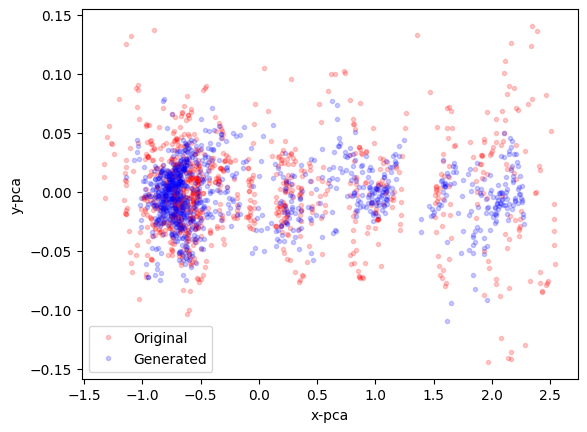

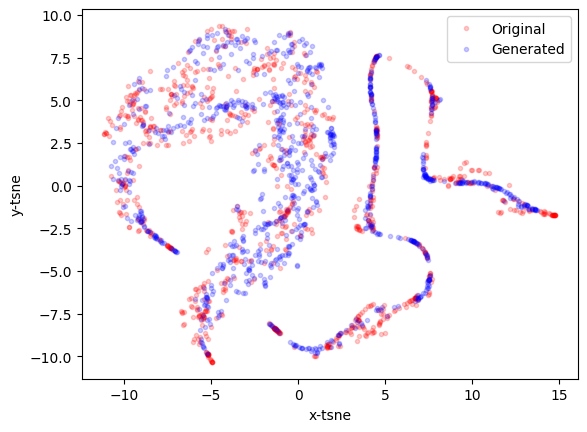

In [24]:
plot_distribution_estimate(*low_dimensional_representation(data_train, data_gen, 'pca'), 'pca')
plot_distribution_estimate(*low_dimensional_representation(data_train, data_gen, 'tsne'), 'tsne')